# Notebook: Prompt Classification on Critical Muons
**Critical Muons**: muon events that deposit `<20MeV` in LAr in coincidence with a deposit in Ge within the signal ROI (e.g, 1.8-2.3 MeV).

**Goal**: test our prompt classifier (*cut + RF*) on these events.

In [1]:
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import time
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 45})

In [2]:
def load_dataframe_from_files(dirin, fileprefix, max_files=100):
    import glob
    files = glob.glob(os.path.join(dirin, fileprefix))
    print("[Info] Loading {} files wt prefix:\n{}".format(len(files), fileprefix))
    df = pd.read_csv(files[0], comment='#', index_col=False)
    for file in files[1:max_files]:
        print(".", end='')
        dftmp = pd.read_csv(file, comment='#', index_col=False)
        df = pd.concat([df, dftmp])
    print("")
    return df

# Load file
The imported file is a csv export of the `SlicedDetection` format.

As in the format, we have information on the event, the deposit, the material and the NPE detected in each slice of the shrouds.

In [3]:
n_inner_slices, n_outer_slices = 12, 20

In [5]:
# Load Ar39
init = time.time()

fileprefix = "ExportCriticalEvent_MERGED*csv"
dfmu = load_dataframe_from_files(".", fileprefix)
dfmu = dfmu[dfmu.columns[:-1]]

print("[Info] Loaded {} Muons in {:.2f} seconds".format(dfmu.eventnumber.nunique(), time.time() - init))
dfmu.head()

[Info] Loading 1 files wt prefix:
ExportCriticalEvent_MERGED*csv

[Info] Loaded 36 Muons in 0.02 seconds


,eventnumber,PID,time,x,y,z,r,material,energydeposition,pedetected,...,OuterSlice10,OuterSlice11,OuterSlice12,OuterSlice13,OuterSlice14,OuterSlice15,OuterSlice16,OuterSlice17,OuterSlice18,OuterSlice19
0,49232,22,23.923200,271.529000,636.533000,380.599000,692.027000,ArgonLiquid,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,49232,22,24.274630,168.930903,612.983223,384.990815,635.834948,ArgonLiquid,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,49232,22,24.354754,164.862831,604.118976,406.941976,626.210420,ArgonLiquid,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,49232,22,24.426093,158.391450,584.853463,413.602918,605.921962,ArgonLiquid,0.0,0,...,0,0,0,0,0,0,0,0,0,0
4,49232,22,24.465468,159.474618,580.133536,424.368249,601.653615,ArgonLiquid,0.0,0,...,0,0,0,0,0,0,0,0,0,0


# Plot the energy depositions of these events

In [6]:
ge_energy = dfmu[dfmu["material"]=="GermaniumEnriched"].groupby("eventnumber").energydeposition.sum()
lar_energy = dfmu[dfmu["material"]=="ArgonLiquid"].groupby("eventnumber").energydeposition.sum()

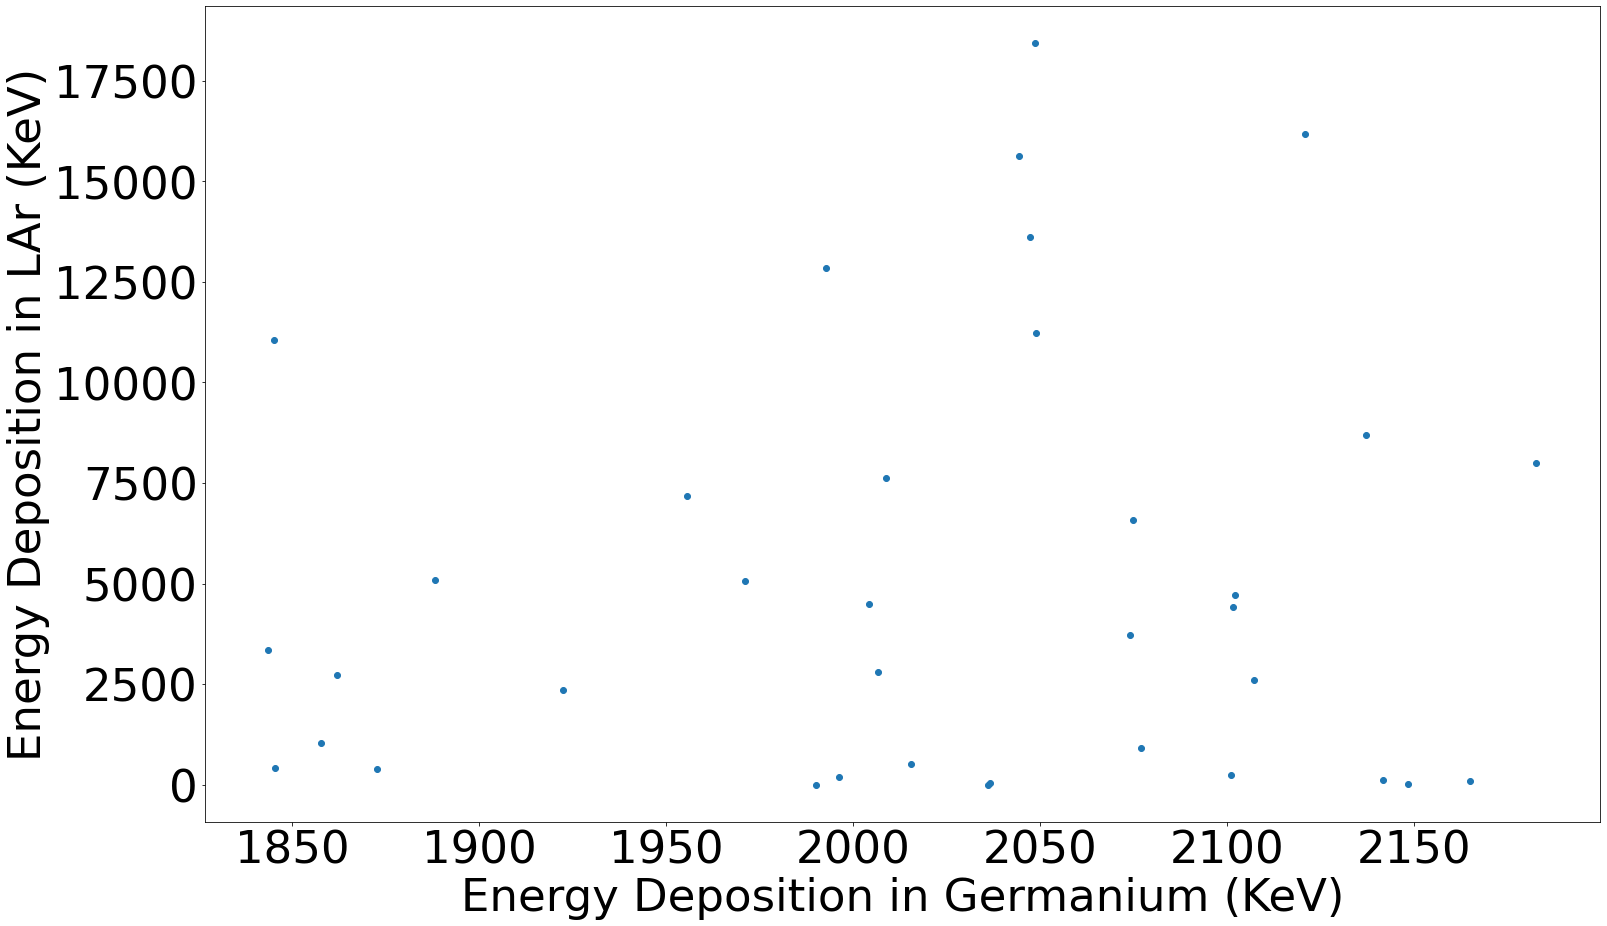

In [7]:
plt.scatter(ge_energy, lar_energy)
plt.xlabel("Energy Deposition in Germanium (KeV)")
plt.ylabel("Energy Deposition in LAr (KeV)")
plt.show()

# Plot the PE Spectrum of these events

In [8]:
lar_pedet = dfmu.groupby("eventnumber").pedetected.sum()

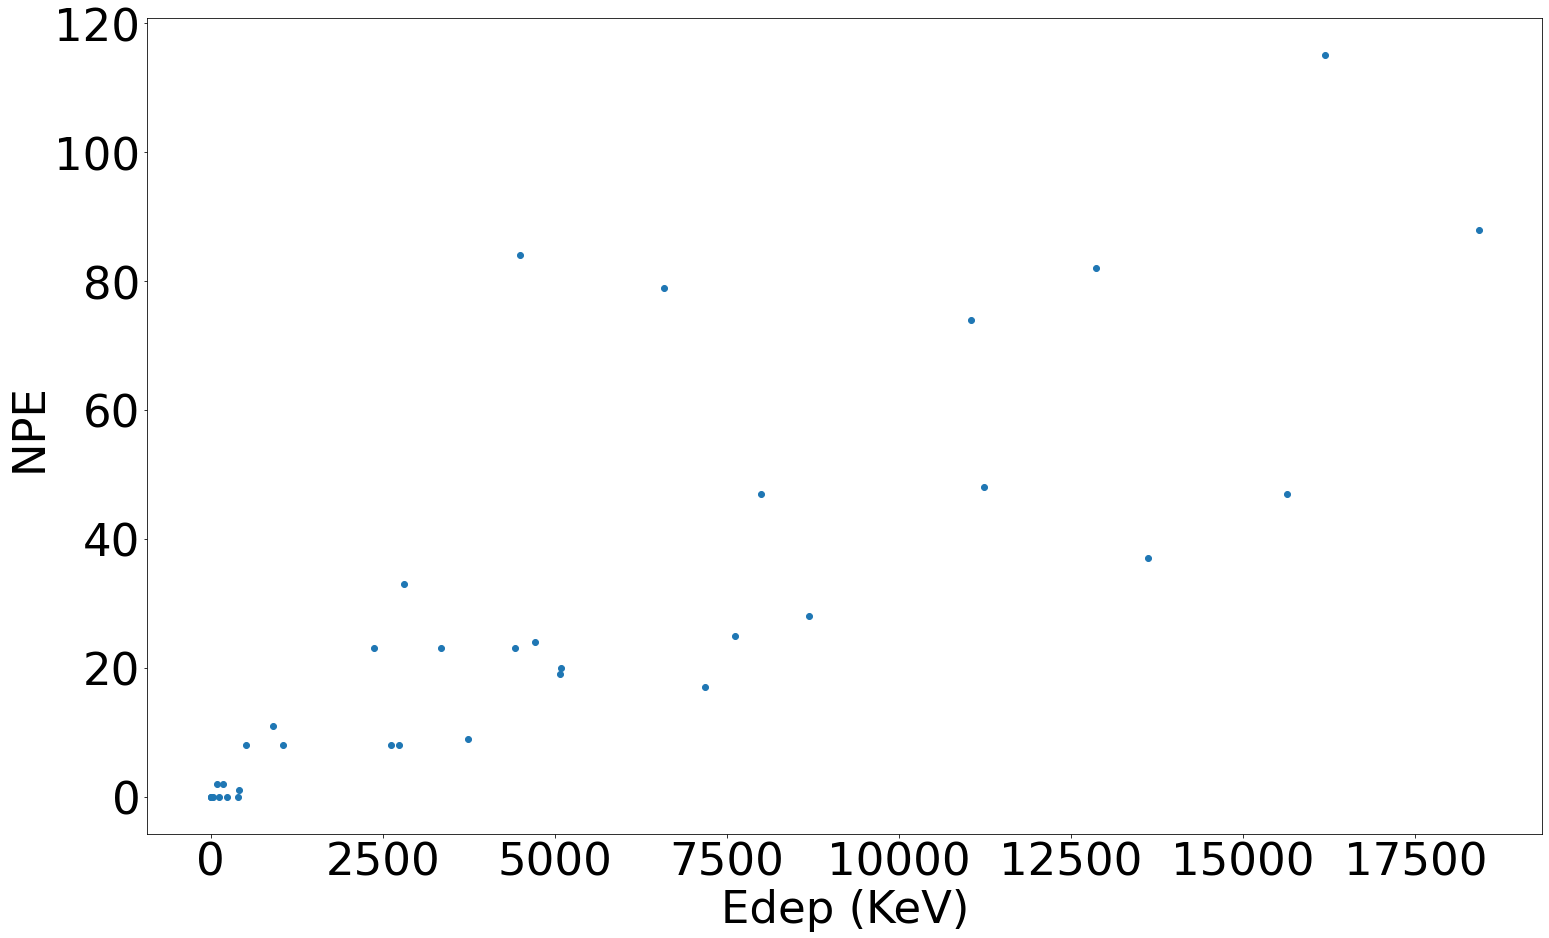

In [11]:
plt.scatter(lar_energy, lar_pedet)
plt.xlabel("Edep (KeV)")
plt.ylabel("NPE")
plt.show()

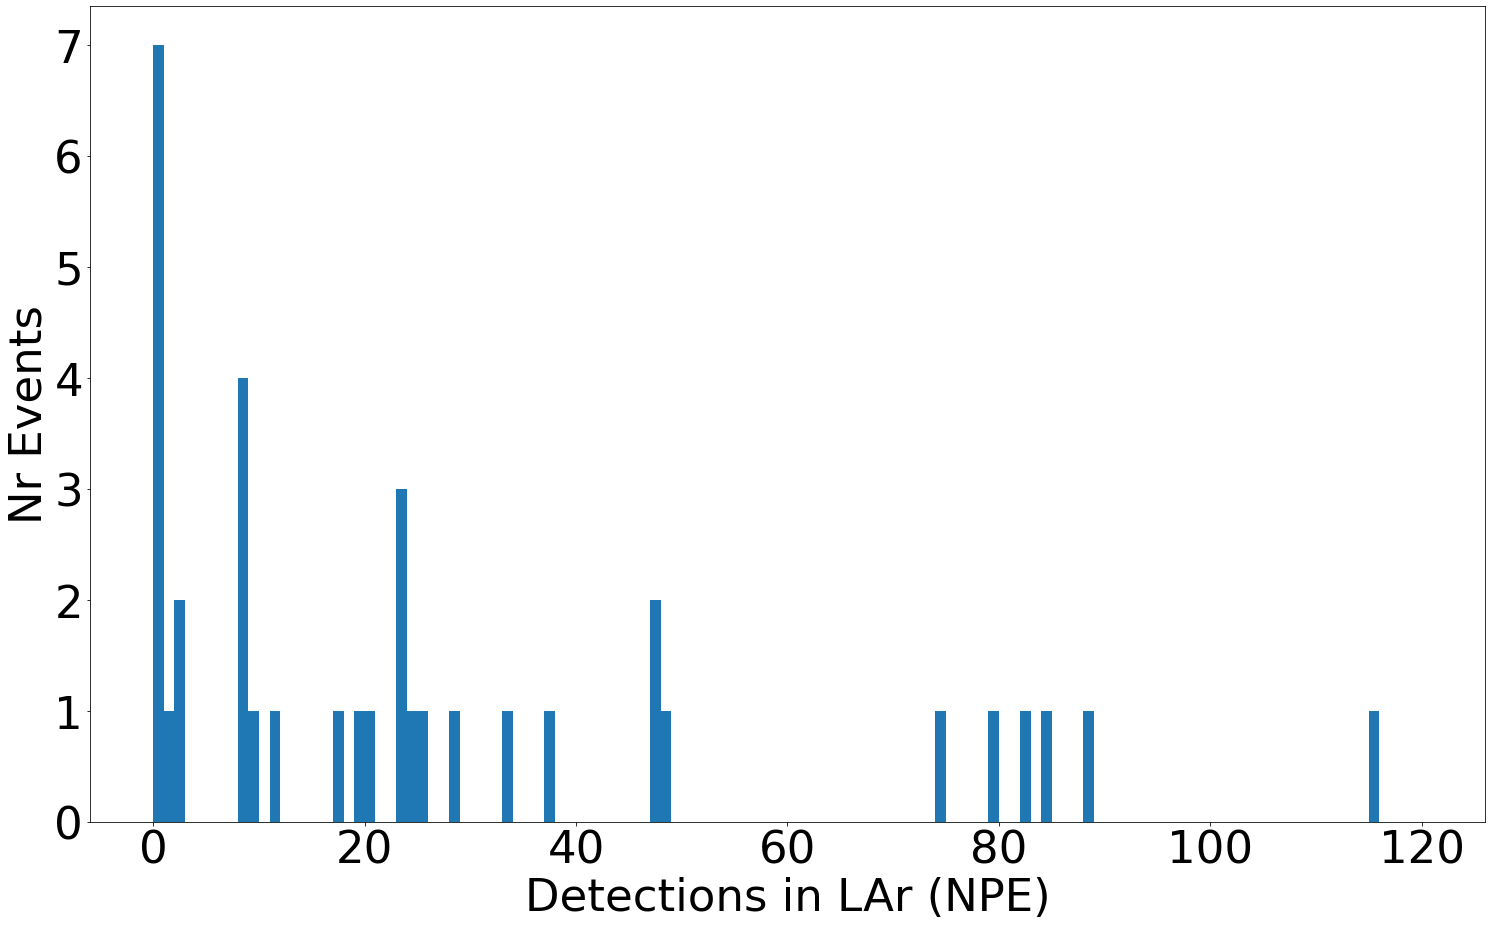

In [12]:
plt.hist(lar_pedet, bins=np.linspace(0, 120, 121))
plt.xlabel("Detections in LAr (NPE)")
plt.ylabel("Nr Events")
plt.show()

# Compute snapshots

In [13]:
def get_first_detection_time(event):
    if len(event[event.pedetected>0])>0:
        return event[event.pedetected>0].time.min()
    return False

def get_detections_on_time_window(event, t0, time_window, n_inner_slices=12, n_outer_slices=20):
    inner_detections, outer_detections = np.zeros(n_inner_slices, dtype=int), np.zeros(n_outer_slices, dtype=int)
    event = event[(event.time>=t0) & (event.time<=t0+time_window)]
    event = event.groupby("eventnumber").sum().reset_index()
    #return event.iloc[:, 3:3+n_inner_slices], event.iloc[:, 3+inner_detections:3+n_inner_slices+n_outer_slices]
    return event

In [14]:
snapshots = pd.DataFrame()
event_t0s = get_first_detection_time(dfmu)
for e in dfmu.eventnumber.unique():
    event = dfmu[dfmu.eventnumber==e]
    t0 = get_first_detection_time(event)
    if t0:
        event = get_detections_on_time_window(event, t0, 10000)
        snapshots = pd.concat([snapshots, event])
    else:
        pass

In [15]:
snapshots = snapshots.reset_index()
cols = ["eventnumber"] + snapshots.columns[12:].to_list()
snapshots = snapshots[cols]

In [25]:
print(f"[Info] Produced Snapshots (NPE>0 + Time<10us): {len(snapshots)}")

[Info] Produced Snapshots (NPE>0 + Time<10us): 29


# compute features

In [16]:
# Create Features
def pe_detected(row):
    return np.sum(row.to_numpy())

def nr_active_slices(row):
    return np.nonzero(row.to_numpy())[0].shape[0]

def mean_npe(row):
    return np.mean(row.to_numpy())

def mean_npe_active(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return np.mean(rownp[rownonzero]) if rownonzero.shape[0]>0 else -1

def std_npe(row):
    return np.std(row.to_numpy())

def std_npe_active(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return np.std(rownp[rownonzero]) if rownonzero.shape[0]>0 else -1

def range_detections(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return rownonzero[-1] - rownonzero[0] + 1 if rownonzero.shape[0]>0 else -1

def spatial_var(row):
    rownp = row.to_numpy()
    ids = np.repeat(np.argwhere(rownp>0), rownp[rownp>0])
    return np.var(ids) if ids.shape[0]>0 else -1

def spatial_std(row):
    rownp = row.to_numpy()
    ids = np.repeat(np.argwhere(rownp>0), rownp[rownp>0])
    return np.std(ids) if ids.shape[0]>0 else -1

In [17]:
# features for rforest
my_features = ["PEDetected_outer", "NActiveSlices_outer", "MeanNPEActive_outer", "SpatialVar_outer", "SpatialRange_outer", 
               "PEDetected_inner", "NActiveSlices_inner", "MeanNPEActive_inner", "SpatialVar_inner", "SpatialRange_inner",
               "PEDetected_tot", "NActiveSlices_tot", "MeanNPEActive_tot"]

init = time.time()
featmu = snapshots
featmu["PEDetected_inner"] = snapshots.iloc[:, 1:1+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
featmu["NActiveSlices_inner"] = snapshots.iloc[:, 1:1+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
featmu["MeanNPEActive_inner"] = snapshots.iloc[:, 1:1+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
featmu["StdNPEActive_inner"] = snapshots.iloc[:, 1:1+n_inner_slices].apply(lambda row: std_npe_active(row), axis=1)
featmu["SpatialRange_inner"] = snapshots.iloc[:, 1:1+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
featmu["SpatialVar_inner"] = snapshots.iloc[:, 1:1+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
featmu["SpatialStd_inner"] = snapshots.iloc[:, 1:1+n_inner_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Mu Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
featmu["PEDetected_outer"] = snapshots.iloc[:, 1+n_inner_slices:1+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
featmu["NActiveSlices_outer"] = snapshots.iloc[:, 1+n_inner_slices:1+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
featmu["MeanNPEActive_outer"] = snapshots.iloc[:, 1+n_inner_slices:1+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
featmu["StdNPEActive_outer"] = snapshots.iloc[:, 1+n_inner_slices:1+n_inner_slices+n_outer_slices].apply(lambda row: std_npe_active(row), axis=1)
featmu["SpatialRange_outer"] = snapshots.iloc[:, 1+n_inner_slices:1+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
featmu["SpatialVar_outer"] = snapshots.iloc[:, 1+n_inner_slices:1+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
featmu["SpatialStd_outer"] = snapshots.iloc[:, 1+n_inner_slices:1+n_inner_slices+n_outer_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Mu Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
featmu["PEDetected_tot"] = featmu["PEDetected_inner"] + featmu["PEDetected_outer"]
featmu["NActiveSlices_tot"] = featmu["NActiveSlices_inner"] + featmu["NActiveSlices_outer"]
featmu["MeanNPEActive_tot"] = featmu["PEDetected_tot"] / featmu["NActiveSlices_tot"]
featmu = featmu.fillna(-1)
print("Compute combined features: {:.3f} sec".format(time.time() - init))

Compute Mu Inner features: 0.021 sec
Compute Mu Outer features: 0.016 sec
Compute combined features: 0.003 sec


# load model

In [18]:
from joblib import load

init = time.time()
rf = load("/home/luigi/Development/ML4NP/ML4GeneralMuons/bonsai_dtrees/rf_10est_5depth.joblib")
print("[Info] Loaded model in {:.2f} seconds".format(time.time() - init))

[Info] Loaded model in 0.97 seconds


# predict

In [19]:
data = featmu
data["y"] = 1
X_rf, y_rf = data.loc[:, my_features], data.loc[:, "y"]
X_rf = np.array(X_rf)
y_rf = np.array(y_rf)

init = time.time()
data["y_rf_pred"] = rf.predict_proba(X_rf)[:, 1]
data["cut_4nas"] = np.where(data.NActiveSlices_outer>=4, 1, 0)
data["cut_60pe"] = np.where(data.PEDetected_tot>60, 1, 0)
print("[Info] RForest predict in {:.3f} seconds".format(time.time() - init))

[Info] RForest predict in 0.004 seconds


In [20]:
data["y_combo"] = np.where(((data.cut_60pe>.5) | ((data.cut_4nas>.5) & (data.y_rf_pred>.5))), 1, 0)

In [21]:
print("True Positive: {}".format(len(data[data.y_combo==1])))
print("False Negative: {}".format(len(data[data.y_combo==0])))

True Positive: 20
False Negative: 9


In [22]:
data[(data.y_combo==0) & (data.cut_4nas<.5)].PEDetected_tot

0     8
9     2
11    2
12    8
18    1
Name: PEDetected_tot, dtype: int64

# Focus: muons with Ge deposit in 1 crystal
I collected a list of `eventnumber` that present the Ge deposition in a **single** crystal.

In this section, I will focus on them.

In [29]:
events1ge = [5922, 14758, 42270, 49232, 50750, 68829, 71269, 79041, 79108, 79512, 82977, 93159]

In [43]:
data[data.eventnumber.isin(events1ge)][["eventnumber", "PEDetected_tot", "NActiveSlices_outer", "cut_4nas", "y_rf_pred", "y_combo"]].sort_values(["cut_4nas", "y_combo"])

,eventnumber,PEDetected_tot,NActiveSlices_outer,cut_4nas,y_rf_pred,y_combo
0,49232,8,3,0,0.614038,0
11,42270,2,2,0,0.235413,0
12,50750,8,3,0,0.024056,0
18,68829,1,1,0,0.265152,0
19,71269,8,4,1,0.057010,0
2,14758,82,11,1,0.953653,1
15,5922,17,6,1,0.981980,1
23,82977,26,10,1,0.998078,1
26,79512,23,5,1,0.592837,1
28,93159,9,4,1,0.792178,1


**Observations:**
1. 2 of them have 0 PE detected (undetected). In fact, we have 10 snapshots instead of 12 events.
1. 4 of them have <4 outer slices, then killed by the preliminary cut.
1. 1 of them is misclassified, it has 8 PE detected.
1. 5 of them are correctly classified as muons.